# Liesel-GAM Demo Notebook

## Setup and Imports

In [23]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam
from liesel_gam.builder.consolidate_bases import consolidate_bases, evaluate_bases

In [24]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [25]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [26]:
df_grid = gen_tp_data(n=5000, grid=True)

In [27]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


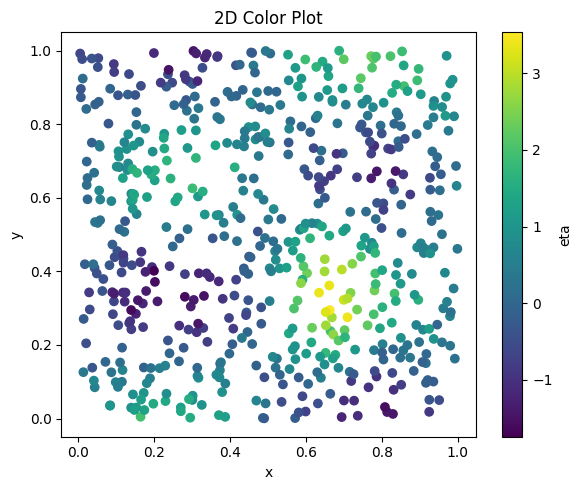

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

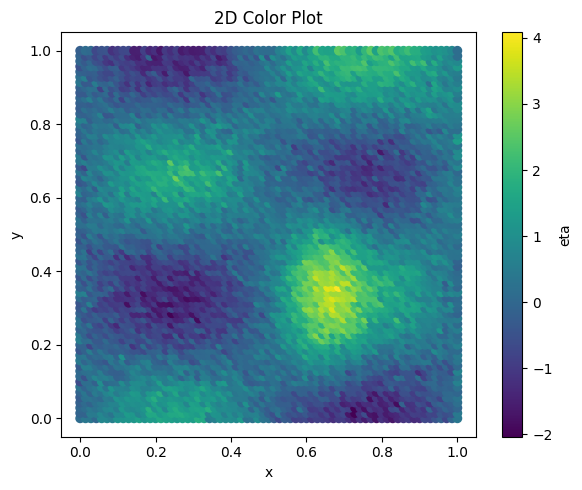

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

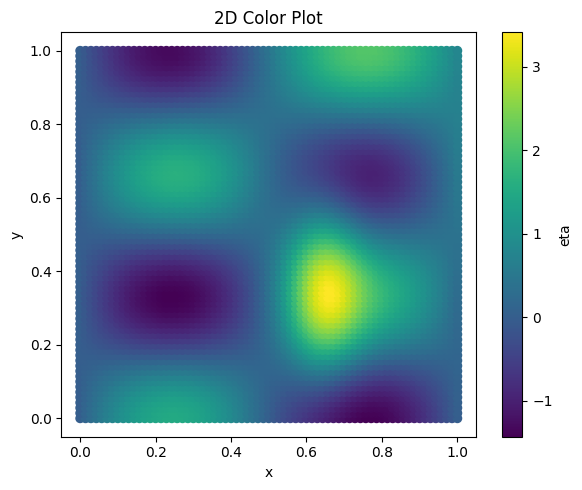

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [31]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [32]:
tb = gam.TermBuilder.from_df(df)

In [33]:
loc += (
    tb.ps("x", k=20),
    tb.ps("y", k=20),
    tb.tx(
        tb.ps("x", k=10),
        tb.ps("y", k=10),
        common_scale=gam.VarIGPrior(1.0, 0.005),
    ),
)

liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.
liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


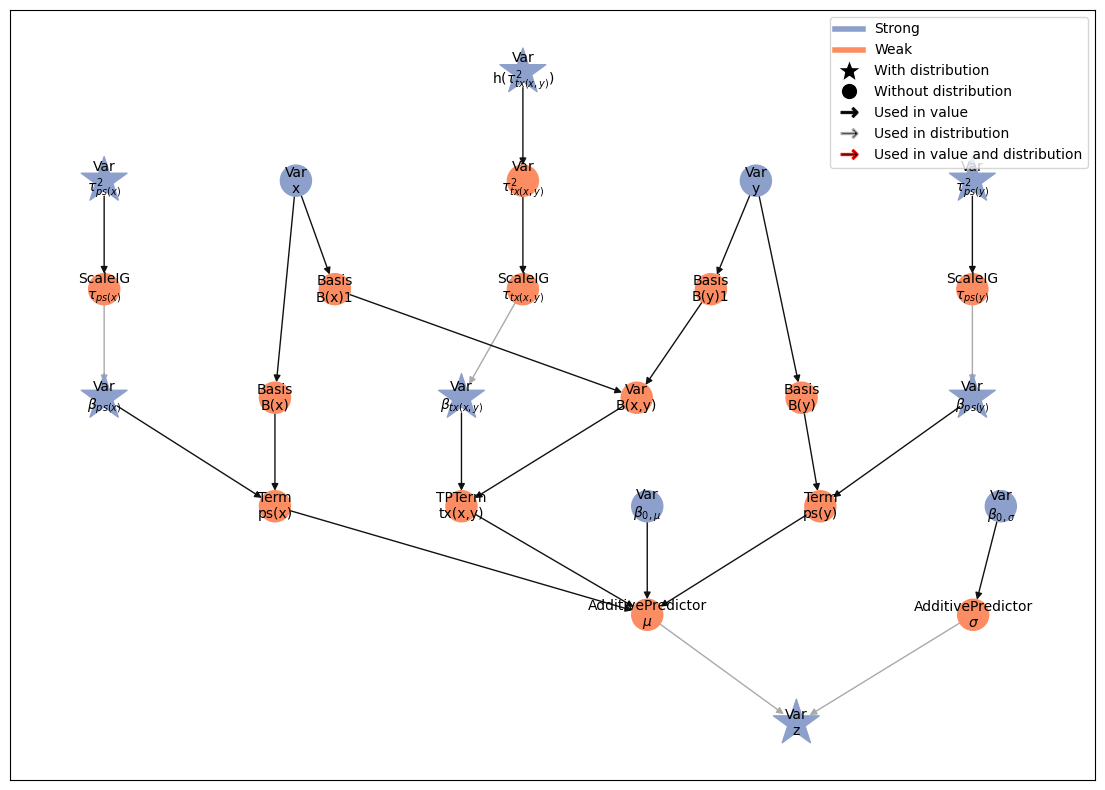

In [34]:
model = lsl.Model([z])
model.plot_vars()

In [35]:
model, bases_model = consolidate_bases(model)

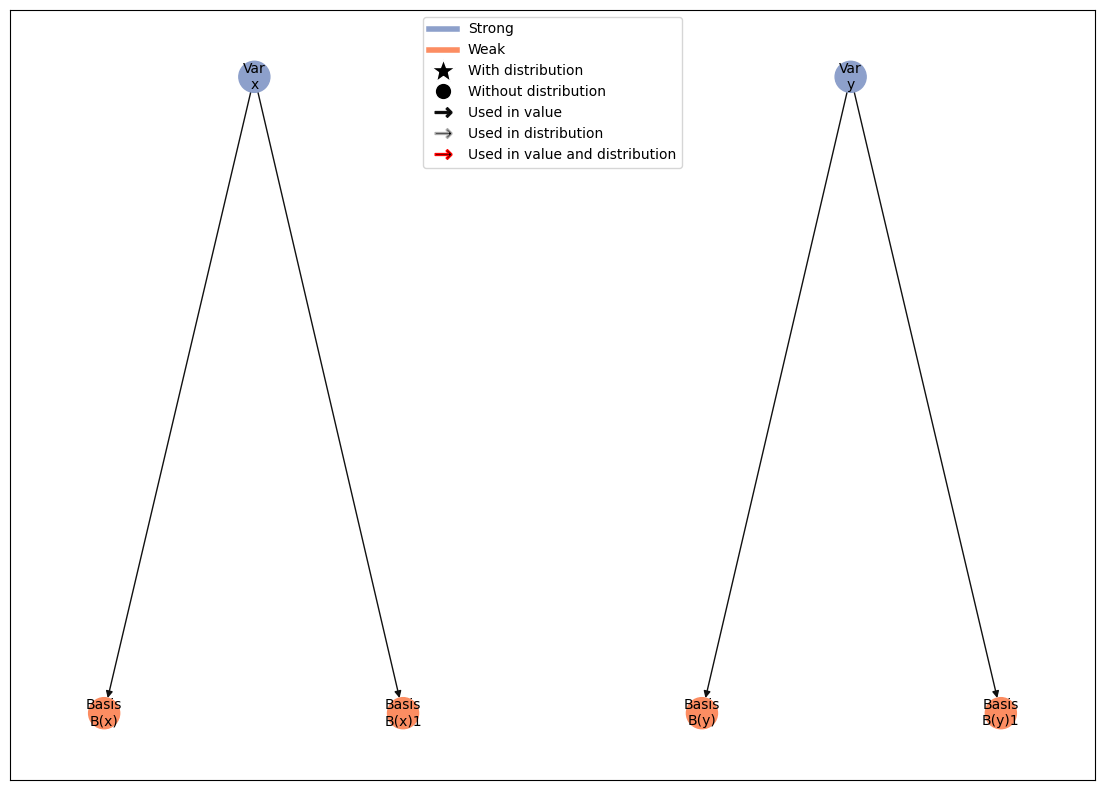

In [36]:
bases_model.plot_vars()

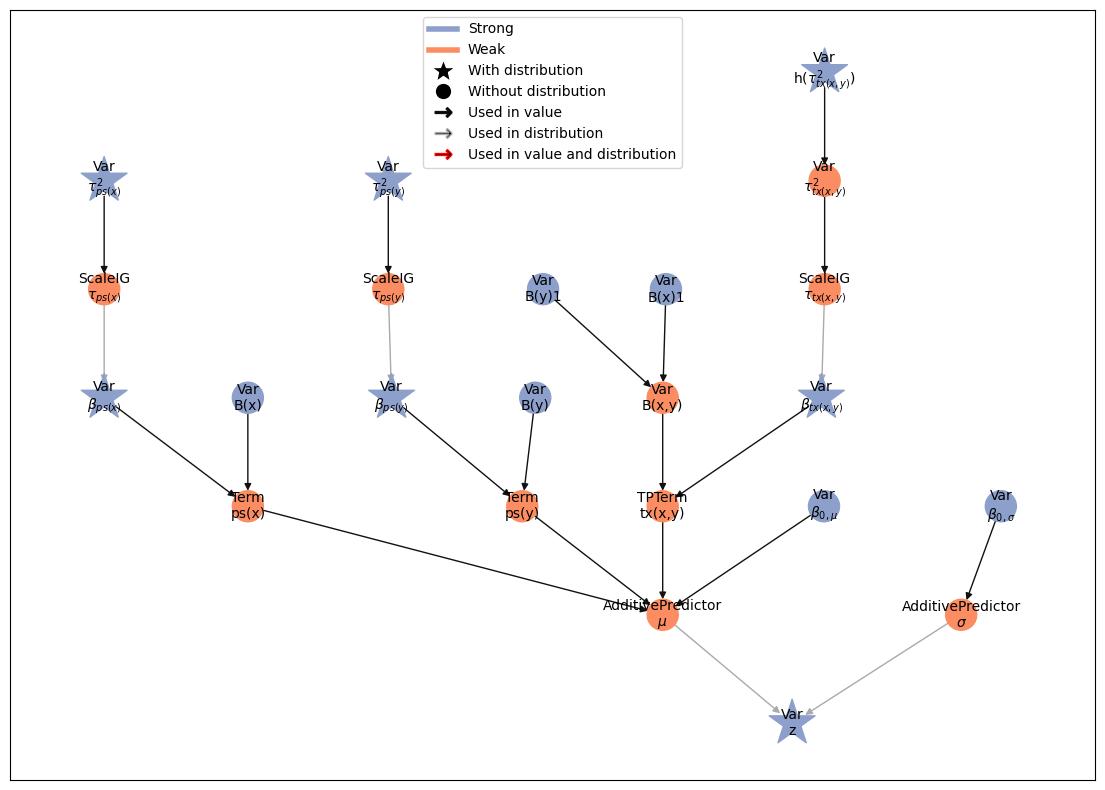

In [37]:
model.plot_vars()

In [38]:
import optax

params = [p.name for p in model.parameters.values() if not p.name.startswith("$\\tau")]
opt = gs.optim_flat(
    model, params, optimizer=optax.adam(learning_rate=1e-5), progress_bar=False
)

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [39]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\tau^2_{ps(x)}$', '$\\beta_{ps(x)}$', '$\\tau^2_{ps(y)}$', '$\\beta_{ps(y)}$', 'h($\\tau^2_{tx(x,y)}$)', '$\\beta_{tx(x,y)}$', '$\\beta_{0,\\mu}$', '$\\beta_{0,\\sigma}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:07<00:00,  1.13chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 19, 16, 22, 22 / 200 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 909.83chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 3, 5, 4, 5 / 25 transitions
liesel.goose.eng

### MCMC summary

In [40]:
summary = gs.Summary(results)
summary

Parameter summary:

                                kernel       mean        sd     q_0.05  \
parameter             index                                              
$\beta_{0,\mu}$       ()     kernel_06   0.340406  0.011198   0.322419   
$\beta_{0,\sigma}$    ()     kernel_07  -1.346283  0.031811  -1.402058   
$\beta_{ps(x)}$       (0,)   kernel_01   0.007068  0.061832  -0.091380   
                      (1,)   kernel_01  -0.010467  0.066090  -0.118969   
                      (2,)   kernel_01   0.007137  0.062073  -0.093637   
...                                ...        ...       ...        ...   
$\beta_{tx(x,y)}$     (79,)  kernel_05  -0.029740  0.037760  -0.093513   
                      (80,)  kernel_05   0.100398  0.092025  -0.046030   
$\tau^2_{ps(x)}$      ()     kernel_00   0.004862  0.002355   0.002208   
$\tau^2_{ps(y)}$      ()     kernel_02   0.002102  0.001275   0.000833   
h($\tau^2_{tx(x,y)}$) ()     kernel_04  37.596272  8.474318  24.701160   

                                 q_0.5     q_0.95  sample_size    ess_bulk  \
parameter             index                                                  
$\beta_{0,\mu}$       ()      0.339906   0.358799          800  712.404764   
$\beta_{0,\sigma}$    ()     -1.346030  -1.295865          800  701.806115   
$\beta_{ps(x)}$       (0,)    0.005243   0.108679          800  540.775419   
                      (1,)   -0.012414   0.099292          800  452.498018   
                      (2,)    0.007740   0.102986          800  476.907259   
...                                ...        ...          ...         ...   
$\beta_{tx(x,y)}$     (79,)  -0.030385   0.032562          800  295.749711   
                      (80,)   0.095968   0.252075          800  181.337152   
$\tau^2_{ps(x)}$      ()      0.004321   0.009120          800  446.937067   
$\tau^2_{ps(y)}$      ()      0.001738   0.004454          800  258.257317   
h($\tau^2_{tx(x,y)}$) ()     36.988241  51.843358          800  207.270156   

                               ess_tail      rhat  
parameter             index                        
$\beta_{0,\mu}$       ()     672.141866  0.999511  
$\beta_{0,\sigma}$    ()     769.882574  1.000003  
$\beta_{ps(x)}$       (0,)   671.374693  1.004824  
                      (1,)   616.761557  1.007402  
                      (2,)   671.185346  1.000573  
...                                 ...       ...  
$\beta_{tx(x,y)}$     (79,)  545.177624  1.004297  
                      (80,)  338.355494  1.028535  
$\tau^2_{ps(x)}$      ()     646.294626  1.008788  
$\tau^2_{ps(y)}$      ()     470.998977  1.004926  
h($\tau^2_{tx(x,y)}$) ()     520.803059  1.013120  

[124 rows x 10 columns]

Error summary:

                                                    count relative
kernel    error_code error_msg            phase                   
kernel_04 1          divergent transition warmup      403  0.10075
                                          posterior    69  0.08625

## Predictions

In [41]:
samples = results.get_posterior_samples()

In [42]:
newdata = {"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()}
newdata = evaluate_bases(newdata, bases_model)

### Predict variables at new x values

In [43]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["tx(x,y)", "$\\mu$", "ps(x)", "ps(y)"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [44]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [45]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,0.344011,0.431524,0.656905,127.951128,268.663354,0.058454,0.025505,1.051377,-0.731716,0.377884,1.402925,-0.707596,1.417115,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,0.428304,0.304156,0.551503,115.916149,263.300950,0.051523,0.021625,1.060532,-0.483132,0.463699,1.324814,-0.510566,1.292624,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,0.526373,0.216482,0.465277,106.475284,254.923416,0.045252,0.018350,1.068019,-0.259824,0.561133,1.280358,-0.191232,1.316453,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,0.634171,0.155649,0.394524,101.249111,267.363682,0.039314,0.015392,1.072724,-0.027968,0.654743,1.247710,0.016318,1.282462,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,0.746755,0.112800,0.335857,93.742973,275.036096,0.034360,0.012855,1.073462,0.178659,0.761087,1.286985,0.138991,1.239678,0.057143,0.0


### Plot fitted functions

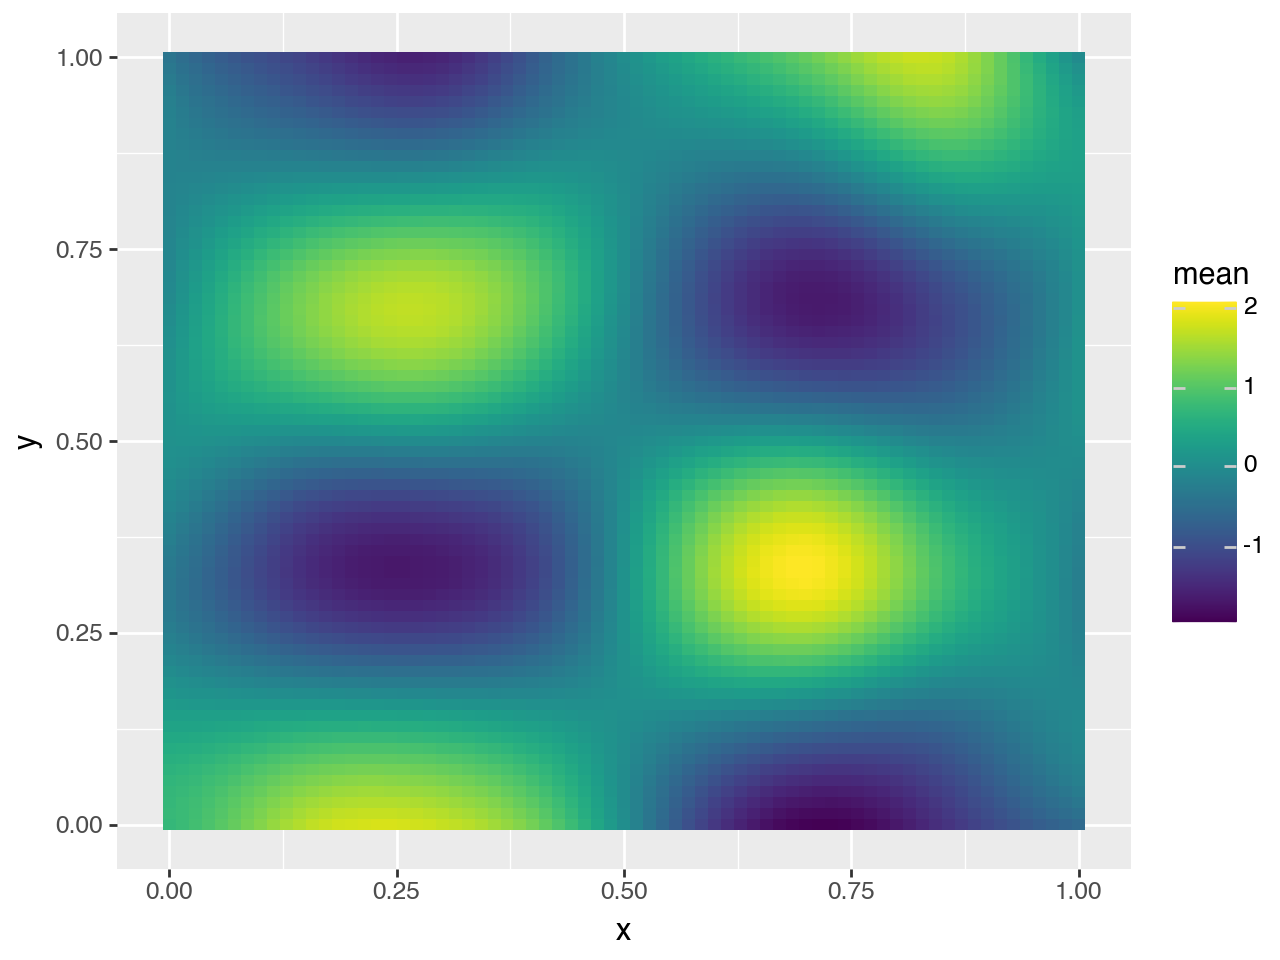

In [46]:
select = predictions_summary["variable"].isin(["tx(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

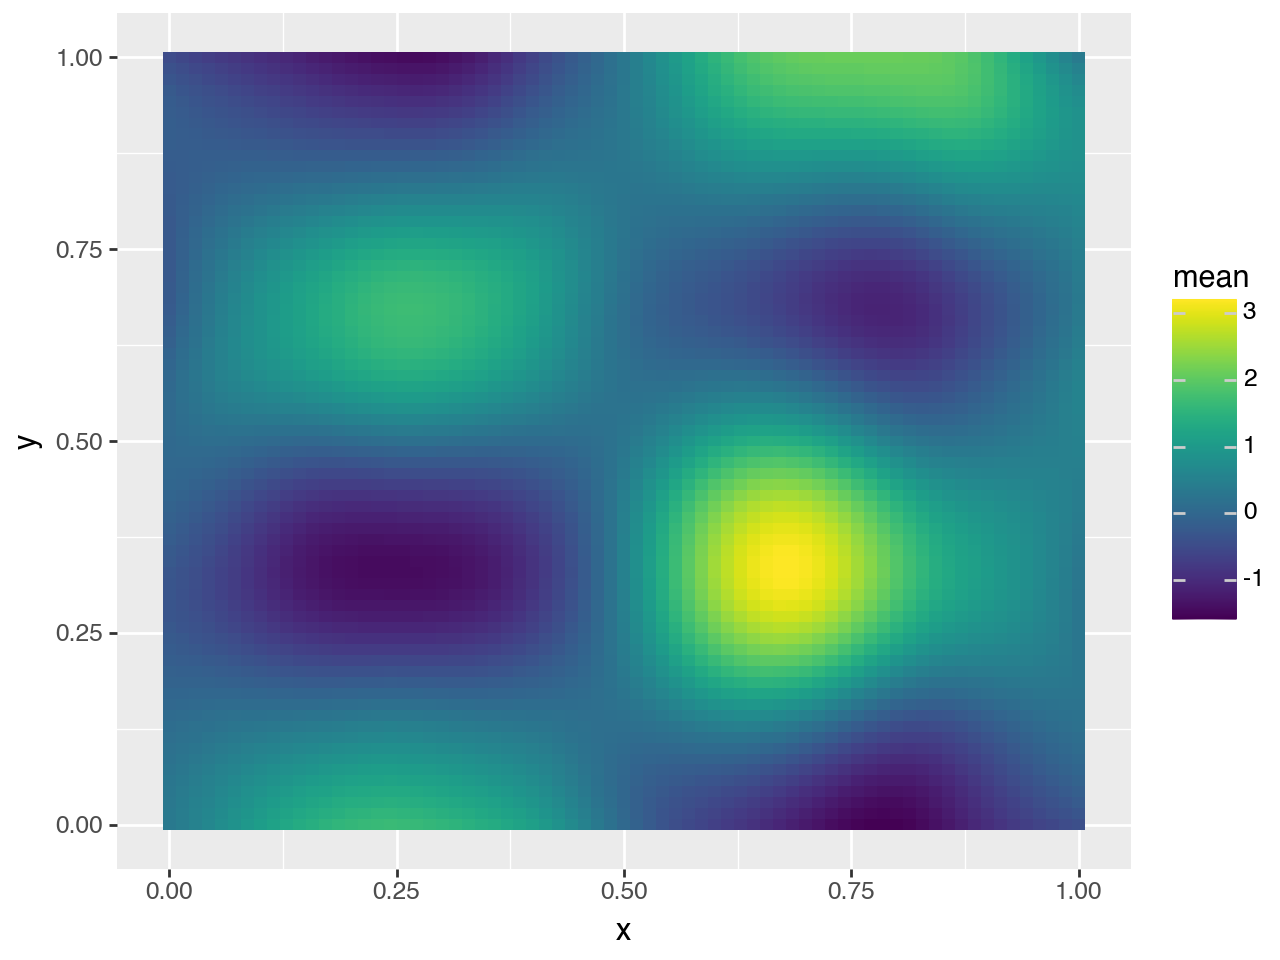

In [47]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

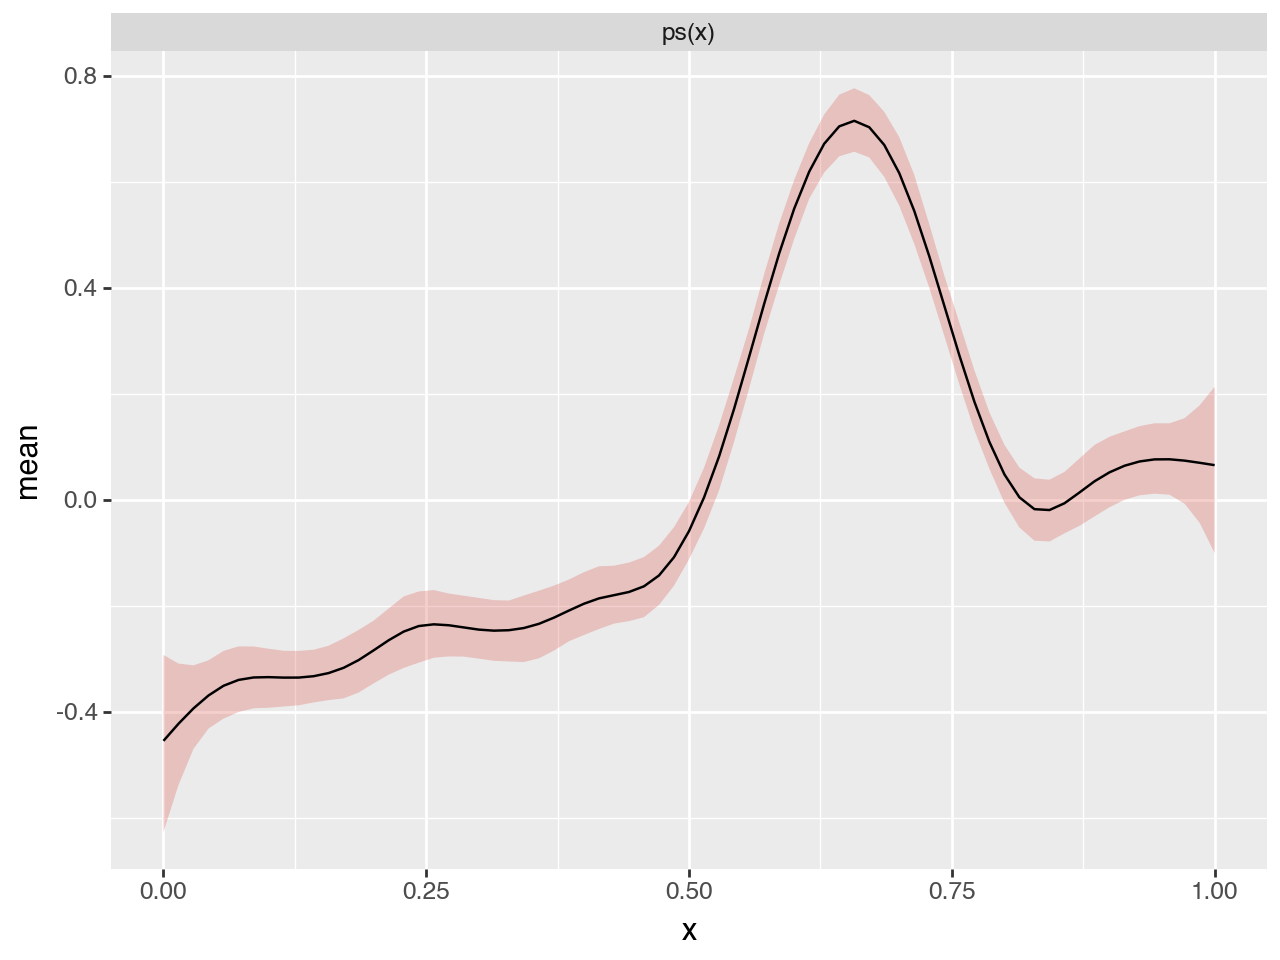

In [48]:
select = predictions_summary["variable"].isin(["ps(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

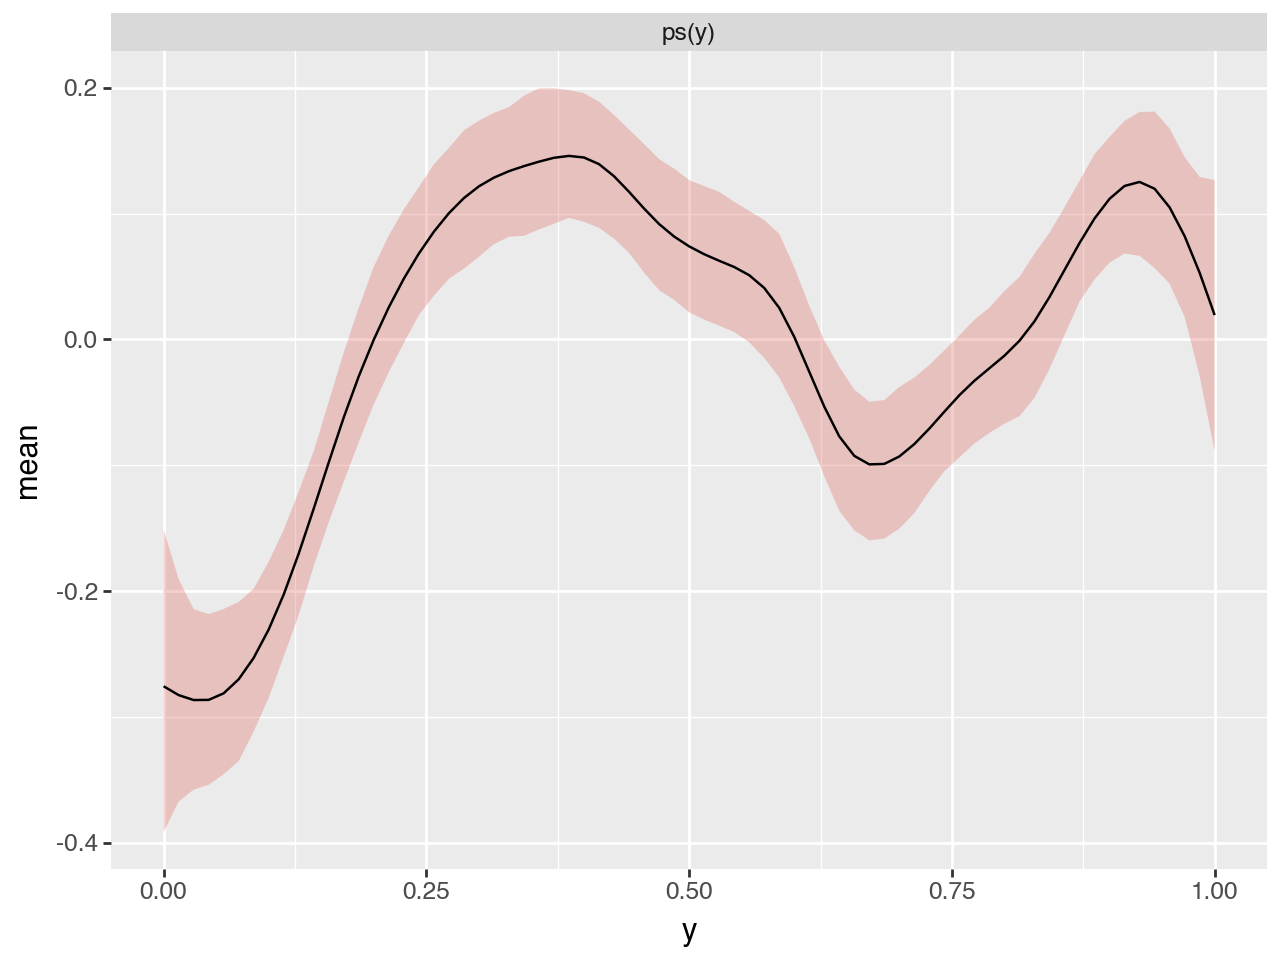

In [49]:
select = predictions_summary["variable"].isin(["ps(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)